# *Could an authenticity of a Banknote be predicted with a simple model?*
![image](banknote.jpg)




## Introduction
The Banknote Dataset involves predicting whether a given banknote is authentic given a number of measures taken from a photograph.

It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 1,372 observations with 4 input variables and 1 output variable. 


### Data Dictionary
The variable names are as follows:

|Name of the feature|Description|Type|
|:---|:-----|:-----|
|variance|Variance of Wavelet Transformed image|Continuous|
|skewness|Skewness of Wavelet Transformed image|Continuous|
|kurtosis|Kurtosis of Wavelet Transformed image|Continuous|
|entropy|Entropy of image|Continuous|
|class|Class (0 for authentic, 1 for inauthentic)| Binary|
The baseline performance of predicting the most prevalent class is a classification accuracy of approximately 50%.

### Source
For more information about the dataset: [Link](http://archive.ics.uci.edu/ml/datasets/banknote+authentication)

Title image: [Link](https://www.vshsolutions.com/wp-content/uploads/2019/02/bankNote1.jpeg)


## Goal and Motivation
Predict the authenticity of a banknote given its feautures and **preferrably** using a simple model rather than a neural network.

---

In [97]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import plotly.express as px
from csv import reader # as pd.read_csv failed because samples are enclosed in strings
%matplotlib inline

# importing ML libraries
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC                   
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV

# to save the model 
import pickle

# for conducting VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [24]:
# Loading the dataset.
opened_file = open('banknote_authentication.csv')
read_file = reader(opened_file)
banknotes = list(read_file)
banknotes[:5] # Just shows top 5 rows 

[['3.6216,8.6661,-2.8073,-0.44699,0'],
 ['4.5459,8.1674,-2.4586,-1.4621,0'],
 ['3.866,-2.6383,1.9242,0.10645,0'],
 ['3.4566,9.5228,-4.0112,-3.5944,0'],
 ['0.32924,-4.4552,4.5718,-0.9888,0']]

- The quotes are to be removed for further processing

In [25]:
bn = []
for row in banknotes:
    for item in row:
        str_item = str(item).rsplit(',') # breaks down the items in the row in separate strings
        bn.append(str_item)
        
bn[:5]        

[['3.6216', '8.6661', '-2.8073', '-0.44699', '0'],
 ['4.5459', '8.1674', '-2.4586', '-1.4621', '0'],
 ['3.866', '-2.6383', '1.9242', '0.10645', '0'],
 ['3.4566', '9.5228', '-4.0112', '-3.5944', '0'],
 ['0.32924', '-4.4552', '4.5718', '-0.9888', '0']]

- This is much better. Now I am going to convert it into a DataFrame

In [26]:
# Assiging column names
col_names=['variance', 'skewness', 'kurtosis', 'entropy', 'class']

# To DataFrame object
df = pd.DataFrame(bn, columns=col_names)

In [27]:
# Converting the dataframe to float Dtype
df = df.astype(float)

---
## Data Cleaning

#### Identification and Treatment of the columns with zero or very low variance

In [28]:
# Number of unique values in each column. This is to check if we have any column with a single value
for col in df.columns:
    num = df[col].nunique()
    percentage = float(num) / df.shape[0] * 100
    print('{}, {}, {}'.format(col, num, percentage))

variance, 1338, 97.52186588921283
skewness, 1256, 91.54518950437318
kurtosis, 1270, 92.56559766763849
entropy, 1156, 84.25655976676384
class, 2, 0.1457725947521866


**Observations:**
- All the features contain a lot of unique values (hence, can not be taken as ordinal or categorical features)
- Lots of uniqueness is found among all the features 

#### Identification and Treatment of the Duplicated Rows

In [29]:
print('The number of duplicated rows are: ', df.duplicated().sum())

The number of duplicated rows are:  24


In [30]:
print('Shape with the duplicated rows: ',df.shape)
df = df.drop_duplicates()
print('Shape w/o duplicated rows: ', df.shape)

Shape with the duplicated rows:  (1372, 5)
Shape w/o duplicated rows:  (1348, 5)


#### Identification of Outliers
- I am leaving this part. Given the nature of the problem, I find that it might not be the best idea to lose the anomalies as anomalies might be the indicative of the unauthentic banknotes. It is not a decision. I just leave them as they are for now

---

## Summary Statistics and Exploration

In [31]:
print('The shape of the dataframe: ',df.shape)

The shape of the dataframe:  (1348, 5)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1348 non-null   float64
 1   skewness  1348 non-null   float64
 2   kurtosis  1348 non-null   float64
 3   entropy   1348 non-null   float64
 4   class     1348 non-null   float64
dtypes: float64(5)
memory usage: 63.2 KB


- Its a small dataset with, apparently, **no** null values.
- Features are in float64 Dtypes

In [33]:
df.describe()

,variance,skewness,kurtosis,entropy,class
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,0.445785,1.909039,1.413578,-1.168712,0.452522
std,2.862906,5.868600,4.328365,2.085877,0.497925
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.786650,-1.627000,-1.545600,-2.393100,0.000000
50%,0.518735,2.334150,0.605495,-0.578890,0.000000
75%,2.853250,6.796025,3.199800,0.403863,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


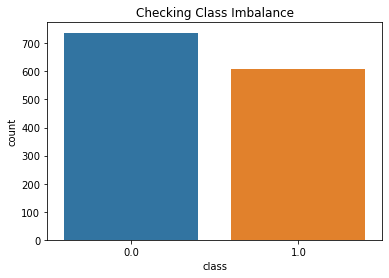

In [34]:
sns.countplot(x=df['class'])
plt.title('Checking Class Imbalance')
plt.show()

- The class Imbalance does not seem to significant. Though it was expected.

Lets move on to visualize the whole dataset

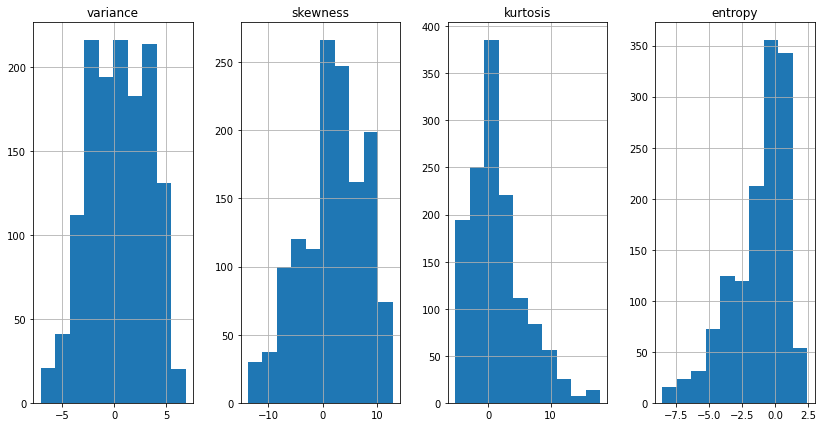

In [35]:
df.iloc[:,:-1].hist(bins=10,figsize=(14,7),layout=(1,4))
plt.show()

- The distributions are roughly Gaussian

<Figure size 720x720 with 0 Axes>

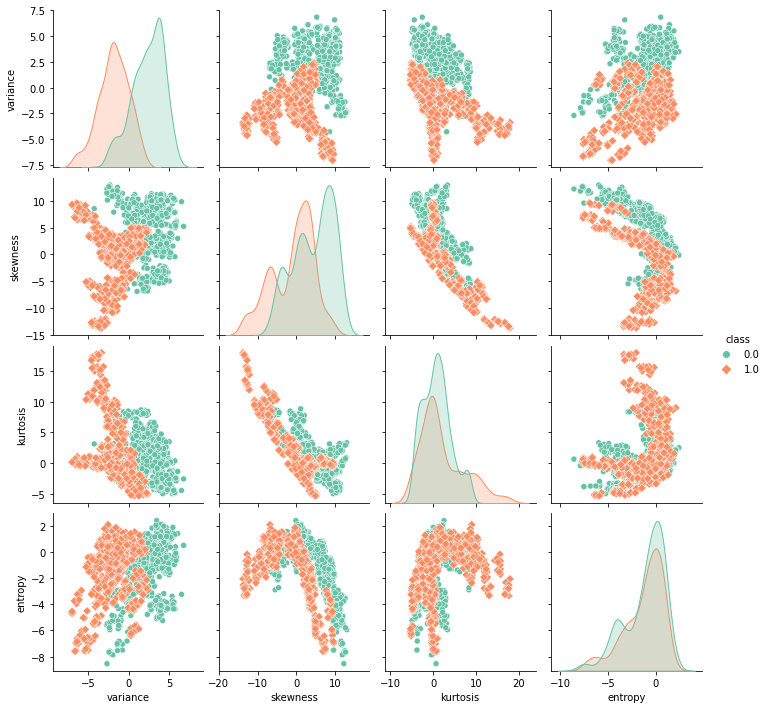

In [36]:
plt.figure(figsize=(10,10)) 
sns.pairplot(df, hue='class',kind="scatter", markers=["o", "D"], palette="Set2")
plt.show()

- From the above plots it is apparent that the classes are well distributed
- The `variance` seems to be most promising to help distinguishing between the classes


## Feature Selection and Dimension Reduction
It is important to note that all of the features are numerical whereas the target variable is a Categorical Output

Lets also check the Correlations in the data

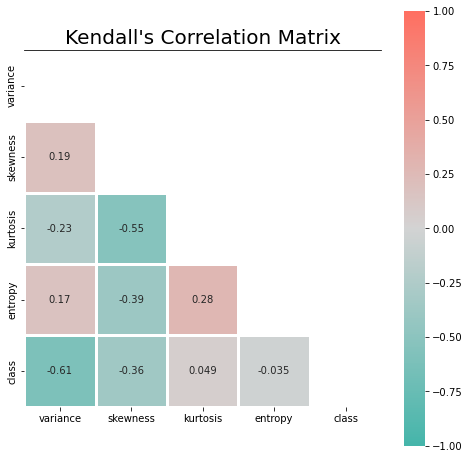

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
corr = df.corr(method='kendall')
colors = ['#45b5aa', 'lightgray', '#ff6f61']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
sns.heatmap(corr,
            mask=mask,
            square=True, 
            linewidth=2.5, 
            vmax=1, vmin=-1, 
            cmap=cmap, 
            cbar=True, 
            ax=ax,annot=True)


ax.spines['top'].set_visible(True)
plt.title('Kendall\'s Correlation Matrix', size=20)
plt.show()

- Certainly, there are a few hints of Collinearity. It can be seen that `Skewness` and `kurtosis` have a highly (negative) correlation
- With respect to the target variable, the `class`, the feature `variance` seems to be the most promising feature

#### Check for MultiCollinearity

In [38]:
# the independent variables set
X = df.iloc[:,:-1]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

    feature       VIF
0  variance  1.361586
1  skewness  3.331757
2  kurtosis  1.895731
3   entropy  2.146062


- Generally, a VIF above 5 indicates a high MultiCollinearity. In such case, the dataset can not be suspected for the presence of Multicollinearity.

Principle Component Analysis (PCA) can be used to take out the MultiCollinearity as well as reduce the dimension of the dataset

## Modelling

In [39]:
models = []
models.append(('Logistic_Regression', LogisticRegression()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('Decision_Tree_Classifier', DecisionTreeClassifier()))
models.append(('Random_Forest_Classifier', RandomForestClassifier()))
models.append(('Linear_SVM', LinearSVC(dual=False)))

Test Accuracy with Logistic_Regression is 0.992
Test Accuracy with KNeighborsClassifier is 0.998
Test Accuracy with Decision_Tree_Classifier is 0.986
Test Accuracy with Random_Forest_Classifier is 0.996
Test Accuracy with Linear_SVM is 0.993


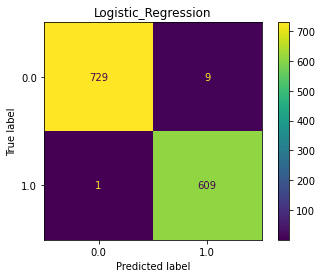

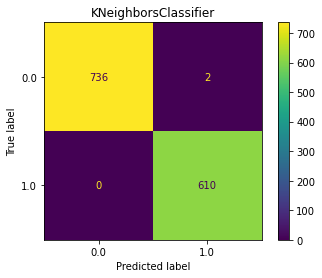

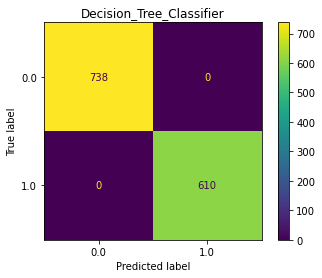

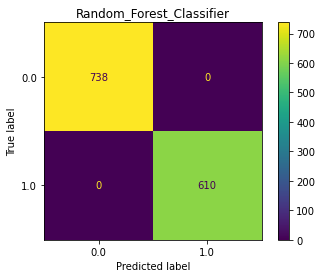

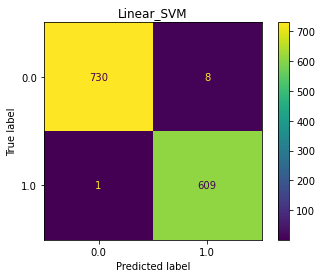

In [40]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

for name, model in models:
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('PCA', PCA()))
    steps.append((name, model))
    pipeline = Pipeline(steps=steps)
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model using cross-validation
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Test Accuracy with {} is {:.3f}'.format(name, np.mean(scores)))
    pipeline.fit(X, y)
    y_pred = cross_val_predict(pipeline, X, y, cv=10)
    #conf_mat = confusion_matrix(y, y_pred)
    plot_confusion_matrix(pipeline, X, y)
    plt.title(name)

- We are having some amazing test accuracy scores. Usually, such scores should not be there without a solid reason backing up. However, this was a fairly simple problem. 

Still, I'd want to run some Overfitting tests to check if everything is right and the model should be trusted
#### Overfitting Analysis

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
for name, model in models:
    
    if name == 'Logistic_Regression' and 'Linear_SVM' and 'KNeighborsClassifier':
        pipe = Pipeline([('sc', StandardScaler()),('PCA', PCA()), (name, model)])
        pipe.fit(X_train, y_train)
        print('For {}:\nTraining Score = {:.3f} AND Test Score = {:.3f}'.format(name, pipe.score(X_train, y_train),
                                                                                   pipe.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        print('The Accuracy Score is =  {}\n'.format(accuracy_score(y_test, y_pred)))
        
    # Since Tree-Based models do not require scaling of the data,
    else:                                                                            
        model.fit(X_train, y_train)
        print('For {}:\nTraining Score = {:.3f} AND Test Score = {:.3f}'.format(name, model.score(X_train, y_train),
                                                                                   model.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        print('The Accuracy Score is =  {}\n'.format(accuracy_score(y_test, y_pred)))
                                                                                    

For Logistic_Regression:
Training Score = 0.992 AND Test Score = 0.993
The Accuracy Score is =  0.40987654320987654

For KNeighborsClassifier:
Training Score = 0.999 AND Test Score = 0.998
The Accuracy Score is =  0.9975308641975309

For Decision_Tree_Classifier:
Training Score = 1.000 AND Test Score = 0.988
The Accuracy Score is =  0.9876543209876543

For Random_Forest_Classifier:
Training Score = 1.000 AND Test Score = 0.988
The Accuracy Score is =  0.9876543209876543

For Linear_SVM:
Training Score = 0.997 AND Test Score = 0.998
The Accuracy Score is =  0.9975308641975309



Almost all the models performed very well on this dataset. **I will choose KNeighbors to build my model on.** 
- It is simple to explain, and usually performs well on Small Datasets. 
- Other than that it has shown a potential to perfectly predict the Negatives. 
    - That is, I am most concerned about none of the unauthentic notes should be marked as Authentic
    


### Hyperparameter Optimization

In [69]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [84]:
# Parameters for GridSearch 
param_grid = {
         'kneighborsclassifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'kneighborsclassifier__leaf_size':np.arange(20, 40, 2),
         'kneighborsclassifier__n_neighbors':np.arange(1, 10, 1),
         'kneighborsclassifier__weights':['uniform', 'distance']
            }

In [87]:
# Pipeline for KNN
pipe_knn = make_pipeline(StandardScaler(), 
                         PCA(), 
                         KNeighborsClassifier())

gscv = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid, 
                    scoring='accuracy', 
                    cv=10, 
                    refit=True, 
                    n_jobs=-1)

gscv = gscv.fit(X_train, y_train)
print('The best score I got: ', gscv.best_score_)
print('\n')
print('Using these params: ', gscv.best_params_)

0.9978835386338186
{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__leaf_size': 20, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


- Lets use the model obtained through hyperparameter optimization of the pipeline. 

In [95]:
# Obtaining the best params and modelling over them
final_model = gscv.best_estimator_
final_model.fit(X_train, y_train)

print('The score by model is: ', model.score(X_test, y_test))

The score by model is:  1.0


In [98]:
final_model

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=1))])

- This is nearly a 100& accuracy

Lets finally look into the confusion matrix to check how false positives and false negatives are showing up with the updated setting 

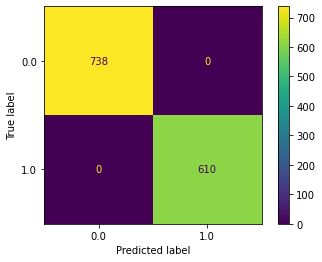

In [93]:
plot_confusion_matrix(final_model, X, y)

---

# Conclusion
- So far, we have achieved perfect accuracy in predicting unauthorized currency bills using Standard Scaling and Principal Componenet Analysis followed by the KNeighborsClassifier modelled with the parameters 
    - `algorithm`: *auto*
    - `leaf_size`: *20*
    - `n_neighbors`: *1*
    - `weights`: *uniform*
    
- Successfully scored a near perfect accuracy without deploying a neural network or other more sophisticated approach
    



I'd welcome any feedback, as that's how our data community is learning and growing itself.


Thank you very much for your considerations, 

S M Ali :)

[LinkedIn's Profile](https://www.linkedin.com/in/s-m-ali-rizvi-a1b550217/) and 
[Github Portfolio](https://github.com/letdatado)